# CPSC 330 Lecture 14

### Lecture plan

- ðŸ‘‹
- **Turn on recording**
- Announcements
- Vectors, distances, neighbours (20 min)
- Cosine similarity (10 min)
- Ratings data (5 min)
- Break (5 min)
- Sparse matrices (15 min)
- KNN for product similarity (5 min)
- Distances with sparse data (15 min)
- T/F questions (10 min)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix, csc_matrix

import seaborn as sns

from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances, euclidean_distances

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
from IPython.core.display import display, HTML

In [3]:
plt.rcParams['font.size'] = 16

## Announcements

(same as Tuesday)

- Midterm grading in progress
- hw6 will be posted ~~at the end of this week or~~ this weekend hopefully
- Lecture 12 screencast posted, please watch before hw6
- Final exam format posted: https://piazza.com/class/kb2e6nwu3uj23?cid=429

## Vectors, distances, neighbours (20 min)

#### Distances between points

- First, we need to talk a bit about vectors and distances.
- Let's return to to the cities dataset from the beginning of the course.

In [4]:
cities_df = pd.read_csv('data/cities_USA.csv', index_col=0)

In [5]:
blue = cities_df.query('vote == "blue"')
red  = cities_df.query('vote == "red"')

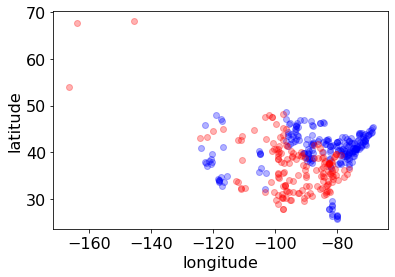

In [6]:
plt.scatter(blue["lon"], blue["lat"], color="blue", alpha=0.3);
plt.scatter(red["lon"], red["lat"], color="red", alpha=0.3);
plt.ylabel("latitude");
plt.xlabel("longitude");

Let's take 2 points:

In [7]:
cities_X = cities_df[['lon', 'lat']]

In [8]:
two_cities = cities_X.sample(2, random_state=30)

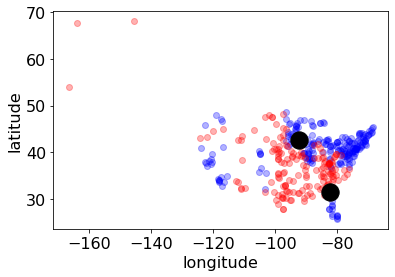

In [9]:
plt.scatter(blue["lon"], blue["lat"], color="blue", alpha=0.3);
plt.scatter(red["lon"], red["lat"], color="red", alpha=0.3);
plt.scatter(two_cities["lon"], two_cities["lat"], color="black", s=300);
plt.ylabel("latitude");
plt.xlabel("longitude");

- For the cities at the two big cicles, what is the _distance_ between them? (Ignoring the curvature of the Earth!)

In [10]:
two_cities

lon        lat
36  -82.249594  31.402780
317 -92.341701  42.673137

Subtract the two cities:

In [11]:
two_cities.iloc[1] - two_cities.iloc[0]

lon   -10.092107
lat    11.270357
dtype: float64

Square the differences:

In [12]:
(two_cities.iloc[1] - two_cities.iloc[0])**2

lon    101.850624
lat    127.020947
dtype: float64

Sum them up:

In [13]:
np.sum((two_cities.iloc[1] - two_cities.iloc[0])**2)

228.8715706068982

Take the square root:

In [14]:
np.sqrt(np.sum((two_cities.iloc[1] - two_cities.iloc[0])**2))

15.128501928707223

The above is called the Euclidean distance. 

In [16]:
euclidean_distances(two_cities)

array([[ 0.        , 15.12850193],
       [15.12850193,  0.        ]])

#### Finding the nearest neighbour

- We can find the closest cities to City 0.
- Let's start with a subset of 4 cities.

In [17]:
dists = euclidean_distances(cities_df[["lat", "lon"]].iloc[:4])
dists

array([[0.        , 0.25726537, 0.54650006, 0.60587695],
       [0.25726537, 0.        , 0.31414736, 0.34945028],
       [0.54650006, 0.31414736, 0.        , 0.16437124],
       [0.60587695, 0.34945028, 0.16437124, 0.        ]])

In [18]:
dists.shape

(4, 4)

These are the distances between City 0 and the other cities:

In [19]:
dists[0]

array([0.        , 0.25726537, 0.54650006, 0.60587695])

We can find the smallest with `np.argmin`:

In [20]:
np.argmin(dists[0])

0

Whoops, that just says city 0 is closest to city 0...

In [21]:
np.fill_diagonal(dists, np.inf)
dists

array([[       inf, 0.25726537, 0.54650006, 0.60587695],
       [0.25726537,        inf, 0.31414736, 0.34945028],
       [0.54650006, 0.31414736,        inf, 0.16437124],
       [0.60587695, 0.34945028, 0.16437124,        inf]])

In [22]:
np.argmin(dists[0])

1

Ok, so the closest city to City 0 is City 1. 

We can do this again with all the cities included, to get the closest overall.

#### Finding the distances to a query point

We can also find the distances to a new "test" or "query" city:

In [24]:
dists = euclidean_distances(cities_X, [[0, 0]])
dists[:10]

array([[ 84.17901524],
       [ 84.30562848],
       [ 84.28113295],
       [ 84.4453635 ],
       [ 85.92913939],
       [ 84.32289429],
       [ 86.10623378],
       [ 86.36094249],
       [ 87.25286283],
       [101.30925538]])

In [25]:
np.argmin(dists)

357

Apparently City 357 is closest to the point $(0,0)$.

#### Using sklearn `NearestNeighbours`

In [26]:
from sklearn.neighbors import NearestNeighbors

In [27]:
nn = NearestNeighbors(n_neighbors=1)
nn.fit(cities_X);

In [28]:
nn.kneighbors([[0,0]])

(array([[81.81189213]]), array([[357]]))

There it is again: City 357, with a distance of around 82.

We can also find the closest city in the training set to city 0:

In [29]:
nn.kneighbors(cities_X.iloc[[0]])

(array([[0.]]), array([[0]]))

- Here we get the same problem as before, that the closest is itself.
- Easiest hack to ignore this: 

In [30]:
nn = NearestNeighbors(n_neighbors=2)
nn.fit(cities_X);

In [31]:
nn.kneighbors(cities_X.iloc[[0]])

(array([[0.        , 0.25726537]]), array([[0, 1]]))

So the closest is City 1.

#### Beyond 2 dimensions

- All this matches our intuition of "distance" in the real world.
- And we could also extend it to points in 3D space.
- In fact, we can extend it to arrays ("vectors") of any length.
- Here is the housing data again (I know I shouldn't be copy/pasting so many times...)

In [32]:
df = pd.read_csv("data/housing.csv", index_col=0)

df_train, df_test = train_test_split(df, random_state=123)

X_train = df_train.drop(columns=['SalePrice'])
y_train = df_train['SalePrice']

X_test = df_test.drop(columns=['SalePrice'])
y_test = df_test['SalePrice']

In [33]:
numeric_features     = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 
                        'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 
                        'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 
                        'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 
                        'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 
                        'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 
                        'ScreenPorch', 'PoolArea', 'MiscVal', 'YrSold']
ordinal_features_reg = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 
                        'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']
ordinal_features_oth = ['BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
                        'Functional',  'Fence']
categorical_features = list(set(X_train.columns) - set(numeric_features) - set(ordinal_features_reg))

ordering = ['Po', 'Fa', 'TA', 'Gd', 'Ex']

In [34]:
numeric_preprocessing = make_pipeline(SimpleImputer(strategy='median'), 
                                      StandardScaler())
ordinal_preprocessing = make_pipeline(SimpleImputer(strategy='most_frequent'), 
                                      OrdinalEncoder(categories=[ordering]*len(ordinal_features_reg)))
categorical_preprocessing = make_pipeline(SimpleImputer(strategy='constant', fill_value="?"),
                                          OneHotEncoder(handle_unknown='ignore', sparse=False))

In [35]:
preprocessing = ColumnTransformer([
    ('numeric', numeric_preprocessing, numeric_features),
    ('ordinal', ordinal_preprocessing, ordinal_features_reg),
    ('categorical', categorical_preprocessing, categorical_features)
])

In [36]:
preprocessing.fit(X_train);

In [37]:
ohe_columns = list(preprocessing.named_transformers_['categorical'].named_steps['onehotencoder'].get_feature_names(categorical_features))
new_columns = numeric_features + ordinal_features_reg + ohe_columns

In [38]:
X_train_enc = pd.DataFrame(preprocessing.transform(X_train), index=X_train.index, columns=new_columns)
X_test_enc = pd.DataFrame(preprocessing.transform(X_test), index=X_test.index, columns=new_columns)

X_train_enc.head()

LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  \
Id                                                                 
1447    -0.046315  1.654400    -0.775646     1.255836  -0.282035   
1124    -0.888437 -0.093394    -0.775646     3.019968  -0.773017   
187     -0.046315 -0.036795     0.647021    -0.508295   0.634466   
1021    -0.420591 -0.342035    -1.486980    -0.508295   1.125448   
68       0.140824  0.038184     0.647021    -0.508295   1.059984   

      YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  ...  \
Id                                                                 ...   
1447     -1.105566    0.491436    0.327430    -0.28498   0.064219  ...   
1124      1.117128   -0.569906   -0.942714    -0.28498   0.297501  ...   
187       0.295697   -0.569906    0.365985    -0.28498   0.023451  ...   
1021      0.972169   -0.569906    1.250588    -0.28498  -1.038776  ...   
68        0.875531    0.367894    1.227027    -0.28498  -0.286837  ...   

      LotConfig_FR3  LotConfig_Inside  MiscFeature_?  MiscFeature_Gar2  \
Id                                                                       
1447            0.0               0.0            1.0               0.0   
1124            0.0               1.0            1.0               0.0   
187             0.0               0.0            1.0               0.0   
1021            0.0               1.0            1.0               0.0   
68              0.0               1.0            1.0               0.0   

      MiscFeature_Shed  MiscFeature_TenC  LandContour_Bnk  LandContour_HLS  \
Id                                                                           
1447               0.0               0.0              0.0              0.0   
1124               0.0               0.0              0.0              0.0   
187                0.0               0.0              0.0              0.0   
1021               0.0               0.0              0.0              0.0   
68                 0.0               0.0              0.0              0.0   

      LandContour_Low  LandContour_Lvl  
Id                                      
1447              0.0              1.0  
1124              0.0              1.0  
187               0.0              1.0  
1021              0.0              1.0  
68                0.0              1.0  

[5 rows x 292 columns]

- Each house is now a length-292 vectors (292 columns).
- We could compute the distance between them.

In [44]:
dists = euclidean_distances(X_train_enc[:3])
dists

array([[ 0.        ,  9.38944568,  6.92285556],
       [ 9.38944568,  0.        , 10.42007981],
       [ 6.92285556, 10.42007981,  0.        ]])

That is, the distance between house 1 and house 2 is:

In [45]:
dists[1,2]

10.420079813360319

Find the most similar training house to test house 1:

In [46]:
nn = NearestNeighbors(n_neighbors=1)
nn.fit(X_train_enc);

In [47]:
nn.kneighbors(X_test_enc.iloc[[1]])

(array([[6.48464496]]), array([[135]]))

You can also ask `NearestNeighbors` to return, say, the 5 nearest neighbours:

Find the 5 most similar training houses to test house 1:

In [48]:
nn = NearestNeighbors(n_neighbors=5)
nn.fit(X_train_enc);

In [49]:
nn.kneighbors(X_test_enc.iloc[1])

ValueError: Expected 2D array, got 1D array instead:
array=[-0.42059121 -0.07303068 -1.4869801  -3.1544927  -2.31142832 -1.68539965
 -0.56990559 -0.94271399 -0.28497976  1.19665728  0.09078342 -0.1712858
  0.75226225 -0.12494295  0.4713169   1.12185796 -0.23230498  0.78133697
 -0.76298931  0.89254471 -0.95298286 -2.38964366  1.66822305  1.47422693
 -0.75391691 -0.68595031  1.13785531 -0.10896508 -0.26487686 -0.07333341
 -0.10879978 -1.39396214  2.          2.          2.          1.
  1.          2.          3.          1.          1.          4.
  1.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          1.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          1.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          1.          0.          0.
  0.          1.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  1.          1.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          1.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          1.          1.          0.          0.          0.
  0.          0.          0.          1.        ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

- You'll see this error a lot. 
- We need to pass in something 2D:

In [50]:
X_test_enc.iloc[1].shape

(292,)

In [51]:
X_test_enc.iloc[[1]].shape

(1, 292)

In [52]:
nn.kneighbors(X_test_enc.iloc[[1]])

(array([[6.48464496, 6.9013241 , 7.25672098, 7.79379333, 7.80278473]]),
 array([[135, 517, 861, 834, 535]]))

## Cosine similarity (10 min)

- So far we've used Euclidean distance. 
- There are other useful alternatives.

In [53]:
??NearestNeighbors

Init signature:
NearestNeighbors(
    *,
    n_neighbors=5,
    radius=1.0,
    algorithm='auto',
    leaf_size=30,
    metric='minkowski',
    p=2,
    metric_params=None,
    n_jobs=None,
)
Source:        
class NearestNeighbors(KNeighborsMixin, RadiusNeighborsMixin,
                       UnsupervisedMixin, NeighborsBase):
    """Unsupervised learner for implementing neighbor searches.

    Read more in the :ref:`User Guide <unsupervised_neighbors>`.

    .. versionadded:: 0.9

    Parameters
    ----------
    n_neighbors : int, default=5
        Number of neighbors to use by default for :meth:`kneighbors` queries.

    radius : float, default=1.0
        Range of parameter space to use by default for :meth:`radius_neighbors`
        queries.

    algorithm : {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'
        Algorithm used to compute the nearest neighbors:

        - 'ball_tree' will use :class:`BallTree`
        - 'kd_tree' will use :class:`KDTree`
        - 'brute

- A particularly useful/popular is Cosine similarity.
- This is the cosine of the angle between two vectors.
  - If the angle is small, they are considered more similar.
  - Zero angle means a cosine of 1 (most similar).
  - If the angle is large, they are more different.
  - 180 degree angle means a cosine of 0 (least similar).
  

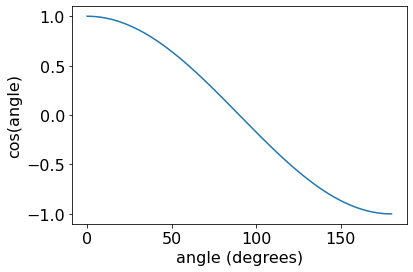

In [54]:
x = np.linspace(0,180,1000)
plt.plot(x,np.cos(x/180*np.pi));
plt.xlabel("angle (degrees)");
plt.ylabel("cos(angle)");

- Because this is a similarity rather than a distance, everything is backwards.
- We had the same thing with mean squared error vs. the $R^2$ score in regression, for example.

In [55]:
nn = NearestNeighbors(n_neighbors=5, metric='cosine')
nn.fit(X_train_enc);

In [56]:
nn.kneighbors(X_train_enc.iloc[[1]])

(array([[0.        , 0.11861795, 0.13285294, 0.13464541, 0.15021607]]),
 array([[  1, 407, 174, 780, 242]]))

- We can see above that the first training example has a score of 0 with itself.
- sklearn is taking 1 minus the cosine similarity so that smaller values mean more similar, to be consistent with the distances.
- Cosine similarity is between -1 and 1, sklearn cosine distance is between 0 and 2. 

In [57]:
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances, euclidean_distances

In [58]:
cosine_similarity(X_train_enc)[1,407]

0.8813820462016351

In [59]:
cosine_distances(X_train_enc)[1,407]

0.11861795379836493

In [60]:
cosine_similarity(X_train_enc).min()

-0.17705982053517716

In [61]:
cosine_similarity(X_train_enc).min()

-0.17705982053517716

#### Euclidean vs. cosine distance

- Cosine similarity relies on an origin, whereas Euclidean distance does not
- If we preprocess our features, the origin would be like an "average" case sort of.

In [62]:
cosine_similarity(X_train_enc)[:5,:5]

array([[1.        , 0.71287876, 0.79768377, 0.74636167, 0.75000074],
       [0.71287876, 1.        , 0.64925291, 0.71424853, 0.6338147 ],
       [0.79768377, 0.64925291, 1.        , 0.8503276 , 0.90210757],
       [0.74636167, 0.71424853, 0.8503276 , 1.        , 0.88156876],
       [0.75000074, 0.6338147 , 0.90210757, 0.88156876, 1.        ]])

is different from

In [63]:
cosine_similarity(X_train_enc-1)[:5,:5]

array([[1.        , 0.86866052, 0.91740762, 0.89392321, 0.89308973],
       [0.86866052, 1.        , 0.83651963, 0.86502662, 0.82556117],
       [0.91740762, 0.83651963, 1.        , 0.93437979, 0.95585103],
       [0.89392321, 0.86502662, 0.93437979, 1.        , 0.94644209],
       [0.89308973, 0.82556117, 0.95585103, 0.94644209, 1.        ]])

whereas

In [64]:
euclidean_distances(X_train_enc)[:5,:5]

array([[ 0.        ,  9.38944568,  6.92285556,  7.93960703,  7.86725903],
       [ 9.38944568,  0.        , 10.42007981,  9.53671484, 10.74674242],
       [ 6.92285556, 10.42007981,  0.        ,  6.22682236,  5.03191983],
       [ 7.93960703,  9.53671484,  6.22682236,  0.        ,  5.62436894],
       [ 7.86725903, 10.74674242,  5.03191983,  5.62436894,  0.        ]])

is the same as

In [65]:
euclidean_distances(X_train_enc-1)[:5,:5]

array([[ 0.        ,  9.38944568,  6.92285556,  7.93960703,  7.86725903],
       [ 9.38944568,  0.        , 10.42007981,  9.53671484, 10.74674242],
       [ 6.92285556, 10.42007981,  0.        ,  6.22682236,  5.03191983],
       [ 7.93960703,  9.53671484,  6.22682236,  0.        ,  5.62436894],
       [ 7.86725903, 10.74674242,  5.03191983,  5.62436894,  0.        ]])

#### Thinking about 2D geometry

We can bring back the cilantro dataset:

In [66]:
cilantro_df = pd.read_csv('data/330-students-cilantro.csv')
cilantro_df.columns = ["meat", "grade", "cilantro"]
cilantro_df.head()

meat  grade cilantro
0   42.0     90      Yes
1   85.0     83       No
2   28.0     83      Yes
3  100.0     80       No
4  100.0     75       No

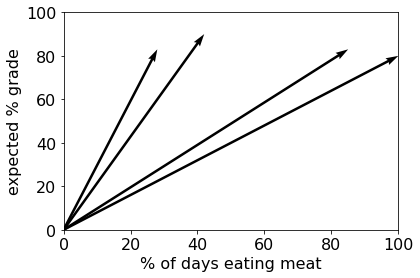

In [67]:
n = 4
plt.quiver(np.zeros(n), np.zeros(n), cilantro_df["meat"][:n], cilantro_df["grade"][:n], angles='xy', scale_units='xy', scale=1);
plt.xlim([0,100]);
plt.ylim([0,100]);
plt.xlabel("% of days eating meat");
plt.ylabel("expected % grade");

- From here we can see that more similar students will have a smaller angle between them.
- In this case the angle cannot be more than 90 degrees so the cosine similarity is between 0 and 1.
- In general here, pairs of students with small Euclidean distance will also have a small Euclidean distance.
- We'll see some deviations from this later today.

## Amazon product dataset (5 min)

We'll be looking at the [Amazon product data set](http://jmcauley.ucsd.edu/data/amazon/). The author of the data set has asked for the following citations:

> Ups and downs: Modeling the visual evolution of fashion trends with one-class collaborative filtering.
> R. He, J. McAuley.
> WWW, 2016.
> 
> Image-based recommendations on styles and substitutes.
> J. McAuley, C. Targett, J. Shi, A. van den Hengel.
> SIGIR, 2015.

We will focus on the Patio, Lawn, and Garden section. Please download the [ratings](http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/ratings_Patio_Lawn_and_Garden.csv) and place them in the data directory with their default filenames. The code below should load the data:

In [68]:
ratings = pd.read_csv("data/ratings_Patio_Lawn_and_Garden.csv", names=("user","item","rating","timestamp"))
ratings.head()

user        item  rating   timestamp
0  A2VNYWOPJ13AFP  0981850006     5.0  1259798400
1  A20DWVV8HML3AW  0981850006     5.0  1371081600
2  A3RVP3YBYYOPRH  0981850006     5.0  1257984000
3  A28XY55TP3Q90O  0981850006     5.0  1314144000
4  A3VZW1BGUQO0V3  0981850006     5.0  1308268800

- Our goal will be to find similar items to recommend given an item. 
- We will do this by recommending items that got similar ratings from the same users.
- Another approach would be to look at features of the items like name, price, etc.
- The methods we'll talk about today would apply equally well there.

Let's compute some summary statistics:

In [69]:
len(ratings)

993490

In [70]:
np.mean(ratings["rating"])

4.006400668350965

Histogram of number of ratings per item:

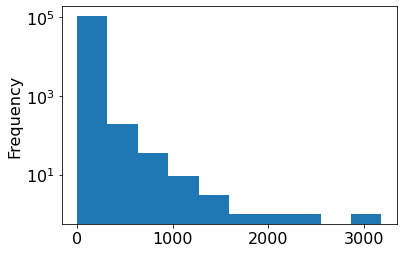

In [71]:
ratings['item'].value_counts().plot.hist(log=True);

Histogram of number of ratings per user:

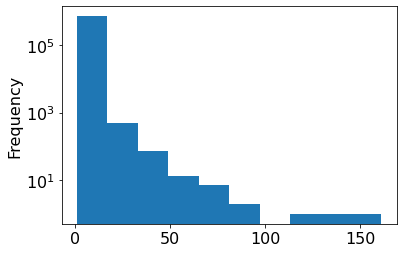

In [72]:
ratings['user'].value_counts().plot.hist(log=True);

- Note the log scales on the vertical axes. 
- We can see some "super items" and "super reviewers".

#### Finding similar items

- The plan: create a matrix of items x users.
  - Use nearest neighbours to find similar items.
  - **The users become the features**.
- Problem: how big is this matrix going to be?

In [73]:
n_items = len(ratings["item"].unique())
n_items

105984

In [74]:
n_users = len(ratings["user"].unique())
n_users

714791

In [75]:
print("Size of full matrix: %.0f GB" % ((n_items*n_users)*8/1e9))

Size of full matrix: 606 GB


![](img/mike_not_gonna_happen.png)

- Is there hope?
- Well, if we were to create such a dataframe, it would be almost entirely zeros:

In [76]:
len(ratings)

993490

In [77]:
n_items*n_users

75756409344

In [78]:
print("Fraction zeros:", 1-len(ratings)/(n_items*n_users))

Fraction zeros: 0.9999868857300841


So, around 99.999% zeros.

Good news: there's a better way! Coming right up after the break.

## Break (5 min)

REMINDER TO RESUME RECORDING

## Sparse matrices in Python (15 min)

Let's take a detour back to word counts:

In [79]:
imdb_df = pd.read_csv('data/imdb_master.csv', index_col=0, encoding="ISO-8859-1")
imdb_df = imdb_df[imdb_df['label'].str.startswith(('pos','neg'))]
imdb_df = imdb_df.sample(frac=0.2, random_state=999) # Take a subsample of the dataset for speed
imdb_df.head()

type                                             review label  \
12438  test  As Jennifer Denuccio used to say on Square Peg...   neg   
5705   test  With Knightly and O'Tool as the leads, this fi...   neg   
11675  test  Take a bad script, some lousy acting and throw...   neg   
9824   test  Strange things happen to Americans Will (Greg ...   neg   
22581  test  Sometimes, you're up late at night flipping th...   pos   

             file  
12438  9946_2.txt  
5705   3886_3.txt  
11675  9259_1.txt  
9824   7593_3.txt  
22581  7824_7.txt

In [80]:
countvec = CountVectorizer()
X_train_counts = countvec.fit_transform(imdb_df["review"])

Let's look at the type of the output:

In [81]:
type(X_train_counts)

scipy.sparse.csr.csr_matrix

In [82]:
X_train_counts

<10000x52863 sparse matrix of type '<class 'numpy.int64'>'
	with 1377321 stored elements in Compressed Sparse Row format>

This is a **sparse matrix**. Why? Look at the shape:

In [83]:
X_train_counts.shape

(10000, 52863)

How many elements total?

In [84]:
np.prod(X_train_counts.shape)

528630000

A lot! How many are nonzero though?

In [85]:
X_train_counts.nnz

1377321

In [86]:
frac_nz = X_train_counts.nnz / np.prod(X_train_counts.shape)
frac_nz

0.00260545371999319

- This happens because most words do not appear in a given document. 
- We get massive computational savings if we **only store the nonzero elements**. 
- There is a bit of overhead, because we also need to **store the locations**:
  - e.g. "location (5,192): 3".
  - However, if the fraction of nonzero is small, this is a huge win.

Here are the nonzero elements in the first review:

In [87]:
print(X_train_counts[0])

  (0, 3106)	4
  (0, 24960)	1
  (0, 12481)	1
  (0, 49837)	1
  (0, 47479)	9
  (0, 40744)	1
  (0, 33007)	6
  (0, 44218)	1
  (0, 34531)	1
  (0, 18886)	1
  (0, 29477)	1
  (0, 33399)	3
  (0, 46925)	19
  (0, 13956)	1
  (0, 52144)	1
  (0, 12198)	1
  (0, 50714)	1
  (0, 47089)	3
  (0, 31099)	6
  (0, 23130)	1
  (0, 52134)	1
  (0, 27489)	1
  (0, 6142)	6
  (0, 12459)	2
  (0, 8620)	2
  :	:
  (0, 45676)	2
  (0, 40869)	1
  (0, 1926)	1
  (0, 47740)	1
  (0, 19036)	1
  (0, 34615)	1
  (0, 3319)	1
  (0, 10238)	1
  (0, 27771)	1
  (0, 47027)	1
  (0, 16808)	1
  (0, 3173)	1
  (0, 20561)	1
  (0, 10406)	1
  (0, 47053)	1
  (0, 41377)	1
  (0, 46341)	1
  (0, 39657)	1
  (0, 33486)	1
  (0, 21708)	1
  (0, 39770)	1
  (0, 30034)	1
  (0, 42681)	1
  (0, 42250)	1
  (0, 51052)	1


- BTW, have you noticed that with `OneHotEncoder` we've been setting `sparse=False`. 
- This is to get it to return a regular numpy array instead of a sparse array, so we didn't have to deal with these.
- If there are a huge number of categories, it may be beneficial to keep them as sparse.
- For smaller number of categories, it doesn't matter much.

#### Working with scipy.sparse matrices

- We won't go into implementation details here, but there are some "gotchas" with `scipy.sparse`.
- For example, with a regular numpy array, `x[i,j]` and `x[i][j]` are equivalent:

In [88]:
x = np.random.rand(10, 10)

In [89]:
x[1, 2]

0.11841066503440678

In [90]:
x[1][2]

0.11841066503440678

In [91]:
(x[1])[2]

0.11841066503440678

This is because `x[1]` returns the first row, and then the `[2]` indexes into that row:

In [92]:
x[1]

array([0.07846112, 0.54362001, 0.11841067, 0.27032155, 0.1637085 ,
       0.01065903, 0.96188241, 0.56988655, 0.58722812, 0.42774069])

In [93]:
row_1 = x[1]
row_1[2]

0.11841066503440678

However, with `scipy.sparse` matrices, things are a bit different:

In [94]:
x_sparse = csr_matrix(x)

In [95]:
x_sparse[1, 2]

0.11841066503440678

In [96]:
x_sparse[1][2]

IndexError: row index (2) out of range

Why?

In [97]:
row_1_sparse = x_sparse[1]

In [98]:
row_1_sparse.shape

(1, 10)

- The sparse matrix returns a different shape, leaving in the first dimension.
- This can be annoying and is something to watch out for.
- In general, I suggest using the `x[1,2]` notation when possible because chaining the `[]` can be problematic in several places (e.g., also pandas).
- However, this is only for numpy, not, say, a list of lists:

In [99]:
lst = [[1, 2, 3], [4, 5, 6], [7, 9]]
lst

[[1, 2, 3], [4, 5, 6], [7, 9]]

In [100]:
lst[0][1]

2

In [101]:
lst[0, 1]

TypeError: list indices must be integers or slices, not tuple

#### sparse matrix operations

Let's try to find the highest word count. But first, review the `axis` keyword:

In [102]:
x = np.random.randint(10, size=(4,5))
x

array([[0, 6, 5, 2, 0],
       [9, 8, 0, 6, 9],
       [4, 9, 9, 7, 9],
       [8, 3, 2, 6, 9]])

In [103]:
np.sum(x)

111

In [104]:
np.sum(x, axis=0)

array([21, 26, 16, 21, 27])

In [105]:
np.sum(x, axis=1)

array([13, 32, 38, 28])

Back to our word counts:

In [106]:
X_train_counts.max()

180

The max for each document:

In [107]:
X_train_counts.max(axis=1).toarray()

array([[19],
       [ 8],
       [56],
       ...,
       [30],
       [ 8],
       [10]])

The document with the highest word count:

In [108]:
np.argmax(X_train_counts.max(axis=1))

5281

- Regular numpy functions work on sparse matrices, although they might be fast/slow depending. 
- You definitely do not want to iterate with loops - make sure you use builtin functions. 
- There are some details here, in that a sparse matrix max be stored row-by-row or column-by-column, and this affects speed.
  - This is beyond the scope of the course, but something to look into if your code is too slow.

#### Back to the ratings data

- We had the same situation as with the word counts
  - Large number of elements, mostly zero
  - So we can make a scipy sparse matrix of the users x items and then do nearest neighbours!

In [109]:
user_mapper = {x : i for i, x in enumerate(ratings["user"].unique())}
item_mapper = {x : i for i, x in enumerate(ratings["item"].unique())}

user_inverse_mapper = {i : x for i, x in enumerate(ratings["user"].unique())}
item_inverse_mapper = {i : x for i, x in enumerate(ratings["item"].unique())}

user_ind = [user_mapper[i] for i in ratings["user"]]
item_ind = [item_mapper[i] for i in ratings["item"]]

X_user_item = csc_matrix((ratings["rating"], (item_ind, user_ind)), shape=(n_items, n_users)).T

In [110]:
type(X_user_item)

scipy.sparse.csr.csr_matrix

In [111]:
X_user_item.shape

(714791, 105984)

In [112]:
X_user_item.nnz

993490

#### EDA

Let's find the following items the item with the most reviews:

In [113]:
idx_most_reviews = np.argmax(np.sum(X_user_item>0, axis=0))
idx_most_reviews

10959

In [114]:
np.max(np.sum(X_user_item>0, axis=0))

3180

Then we can look up the Amazon id:

In [115]:
item_inverse_mapper[idx_most_reviews]

'B000HCLLMM'

And get the URL:

In [116]:
url_amazon = "https://www.amazon.com/dp/%s"
def disp_url(item_id):
    url = url_amazon % item_id
    display(HTML('<a href="%s">%s</a>' % (url,url)))

disp_url(item_inverse_mapper[idx_most_reviews])

## KNN for product similarity (5 min)

Let's find find the 5 items most similar to [GRILL HOGS 18" GRILL CLEANING BRUSH](https://www.amazon.com/dp/B00CFM0P7Y). 

In [117]:
grill_brush = "B00CFM0P7Y"
grill_brush_ind = item_mapper[grill_brush]
grill_brush_vec = X_user_item[grill_brush_ind]

Here is the strategy:

- We have a matrix `X_user_item` of users x items.
- Let's transpose it:

In [118]:
X_item_user = X_user_item.T

In [119]:
X_user_item.shape

(714791, 105984)

In [120]:
X_item_user.shape

(105984, 714791)

In [121]:
type(X_item_user)

scipy.sparse.csc.csc_matrix

In [122]:
type(X_user_item)

scipy.sparse.csr.csr_matrix

- This is now items x users.
- Each item is an observation, and we treat the users as features/columns.
- Assumption: **a similar item is an item that receives similar reviews by the same people.**
- In that case, we can just use nearest neighbours!

In [123]:
nn = NearestNeighbors(n_neighbors=6)
nn.fit(X_item_user);

In [124]:
distances, nearby_items = nn.kneighbors(X_item_user[grill_brush_ind])
nearby_items

array([[ 93652, 103866, 103865,  98897,  72226, 102810]])

The first one is the grill brush itself:

In [125]:
grill_brush_ind

93652

So the neighbours are:

In [126]:
nearby_items = np.squeeze(nearby_items)[1:]
nearby_items

array([103866, 103865,  98897,  72226, 102810])

In [127]:
for item in nearby_items:
    disp_url(item_inverse_mapper[item])

In [128]:
distances

array([[ 0.        , 74.24284477, 75.14652354, 76.51797175, 76.51797175,
        76.51797175]])

How many reviews does the grill brush have?

In [129]:
(X_item_user[grill_brush_ind] > 0).sum()

272

How many reviewers do they have in common?

In [130]:
for item in nearby_items:
    print(np.sum(np.squeeze(X_item_user[grill_brush_ind].toarray()) * np.squeeze(X_item_user[item].toarray()) >0))

37
28
1
1
1


## Distances with sparse data (15 min)


- Is Euclidean distance the best choice?
- Are similar items near each other?
- Let's say there are 2 users, Alice and Bob.

In [131]:
df = pd.DataFrame(data=[[5, 0], [1, 2], [5, 5]], columns=["Alice", "Bob"], index=["Query", "Item 1", "Item 2"])
df

Alice  Bob
Query       5    0
Item 1      1    2
Item 2      5    5

Which item do you consider more similar to the Query item, Item 1 or Item 2?

<br><br><br><br><br><br>

- I would say Item 2, because Alice liked both Item 2 and Query.
- Let's look at them as vectors:

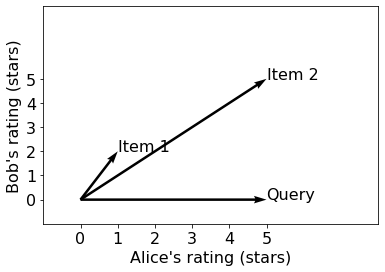

In [132]:
plt.quiver(np.zeros(3), np.zeros(3), df["Alice"], df["Bob"], angles='xy', scale_units='xy', scale=1);
plt.xlim([-1, 8]);
plt.ylim([-1, 8]);
plt.xticks([0,1,2,3,4,5])
plt.yticks([0,1,2,3,4,5])
for ind, val in df.iterrows():
    plt.text(val["Alice"], val["Bob"], ind);
plt.xlabel("Alice's rating (stars)");
plt.ylabel("Bob's rating (stars)");
# plt.axis('equal');

Question: which has a smaller distance to the Query item, Item 1 or Item 2?

In [134]:
dists_df = pd.DataFrame(data=euclidean_distances(df), columns=df.index, index=df.index)
dists_df

Query    Item 1  Item 2
Query   0.000000  4.472136     5.0
Item 1  4.472136  0.000000     5.0
Item 2  5.000000  5.000000     0.0

- Item 1, apparently.
- However, if we look at the **angle** instead of the distance, then we get Item 2:

![](img/cosine_sim.png)

- So we might want to use **cosine similarity**, which looks at the angle instead of the distance.
- But furthermore, what is really the goal here, just similarity?
- Wouldn't it make sense to typically recommend items that are more popular in general?
- Even if we weren't sure whether Item 1 or Item 2 was more similar, Item 2 is more popular, so let's recommend that?
- It turns out cosine similarity helps with that as well.
  - Why? It has to do with high-dimensional intuition again.
  - Combined with the fact that these vectors are actually quite sparse.
  - We won't go into detail here.

#### (From last year's Piazza - to read over later) Notes on Cosine similarity vs Euclidean distance

Q1: Why is a small angle good?

Cosine similarity tries to minimize the angle. An identical product would have an angle of zero, so that would be considered the most similar, which is good. Let's assume for a minute that the ratings were from -5 stars to 5 stars. Then, if you had two products A and B with exact opposite reviews (if I gave product A a 4 stars, then I gave product B -4 stars), those vectors would be pointing in exact opposite directions and have an angle of 180 degrees. So those would be the least similar, which also makes sense. In general, more similar vectors will have smaller angles between them. Does that help?

Q2: Why does cosine similarity promote retrieving popular products?

That is about why minimizing angle makes sense. The popularity thing is a separate question: why is minimizing angle better than minimizing distance? In the case of sparse high-dimensional vectors, you will often have very few nonzeros (i.e. reviewers) in common. Thus, the dot product between any two vectors will often be zero or very close to zero. If the dot product is zero, that means the angle is 90 degrees, which is the largest possible angle here because we don't have negative values. So, in short, most vectors are pointing in different directions from each other. Now, imagine trying to find the closest vector to a query vector. In that case, if you have another vector of the same length but pointing in a different direction, the distance will be greater than the distance between yourself and a tiny vector (near zero). So, the closest vectors by distance will often by vectors with extremely low length (number of reviews, aka popularity). OTOH the angle (cosine similarity) doesn't have this strange property and so tends to work better. Thus, I would say Euclidean distance tends to select very unpopular items rather than saying cosine similarity tends to select very popular items.

Let's use cosine similarity instead of Euclidean distance in `NearestNeighbors`, and find the 5 products most similar to `B00CFM0P7Y`.

In [135]:
nn_cos = NearestNeighbors(n_neighbors=6, metric='cosine')
nn_cos.fit(X_item_user);

In [136]:
distances_cos, nearby_items_cos = nn_cos.kneighbors(X_item_user[grill_brush_ind])
nearby_items_cos

array([[ 93652, 103866, 103867, 103865,  98068,  98066]])

In [137]:
nearby_items_cos = np.squeeze(nearby_items_cos)[1:]
nearby_items_cos

array([103866, 103867, 103865,  98068,  98066])

Let's compare the results of Euclidean vs. cosine distance:

In [138]:
def print_item_pop(items_idx):
    popularity = np.sum(X_item_user[items_idx], axis=1)
    for item in items_idx:
        disp_url(item_inverse_mapper[item])
    for i in range(len(items_idx)):
        print(f"Total stars: {int(popularity[i,0])}")

In [139]:
print("Euclidean items/popularity:")
print_item_pop(nearby_items)

Euclidean items/popularity:


Total stars: 266
Total stars: 205
Total stars: 5
Total stars: 5
Total stars: 5


In [140]:
print("Cosine items/popularity:")
print_item_pop(nearby_items_cos)

Cosine items/popularity:


Total stars: 266
Total stars: 438
Total stars: 205
Total stars: 311
Total stars: 513


The results make sense, as we can expect more popular items given by the cosine metric than the Euclidean distance. 

#### (optional) Scaling

BTW, should we scale our features?

In [141]:
np.mean(X_item_user, axis=0)

matrix([[4.71769324e-05, 4.71769324e-05, 4.71769324e-05, ...,
         9.43538647e-05, 9.43538647e-05, 9.43538647e-05]])

- Should we subtract these means?

<br><br><br><br><br><br>

- Problem: if we do, it would no longer be mostly zeros!
- If we had to store this as a dense matrix, it would be way too large.
- Can we still scale if we can't shift? Sure, although there are some computational issues with sparse matrices.
- It turns out scaled Euclidean and cosine similarity yield the name KNNs.

#### (optional) Intuition in high dimensions

- In the cities case, we had 2 dimensions.
- In the Amazon case, we have

In [142]:
n_users

714791

- A lot of our intuition is not usable in high dimensions.
- Example: you have a circle of radius 1. What fraction of the area is within radius 0.999?

In [143]:
r = 0.999
np.pi*r*r/(np.pi*1*1)

0.9980010000000001

Most of the area, as expected!

- Actually we don't care about the factors, which cancel out.
- And the denominator is 1.
- So the ratio is just $r^2$

In [144]:
r**2

0.998001

You have a sphere of radius 1. What fraction of the volume is within radius 0.999?

In [145]:
r**3

0.997002999

- Still most. 
- OK, what about 700,000 dimensions? Any guesses?

In [146]:
r**n_users

2.5995282301993e-311

- Basically nothing. What about radius 0.999999?

In [147]:
0.999999 ** n_users

0.4892941887508955

All that is to say, don't trust your intuition when there's a huge number of dimensions!

#### Not covered / extensions

- Can I recommend a project _for a specific user_?
- One approach: Can we predict the missing ratings? (And then take high predicted rating.)
- That was the Netflix Prize I mentioned earlier.
- This is covered in CPSC 340 using a method called collaborative filtering.